## Evaluating the efficiency of nuclear segmentation

We numerically evaluate the instance segmentation by identifying object-level errors by comparing the predicted labels to the ground truths.

We generate the ground truths manually using Labkit in Fiji using the following steps: 
1. Open the image and start Labkit via Plugins > Segmentation > Labkit
2. Successively add a new label and annotate a single nucleus instance with the brush tool
3. Export the label image via Save Labeling... and File format > TIF Image

The accuracy of identifying a given nucleus was computed by measuring the overlaped area between the true(T) and predicted(P) nucleus using the intersection-over-union (IoU) score as follows 
$$IoU = \frac {Area (T \cap P) }{Area( T \cup P)}$$

Consider n true objects and m estimated objects in an image. A matrix ${IoU_{Score}}_{mxn}$ is computed with all IoU scores between true objects and estimated objects to identify the best pairing. This is a very sparse matrix because only a few pairs share enough common area to score a nonzero IoU value. 

A detected object is considered a match (true positive, TP) if a ground truth object exists whose intersection over union (IoU) is greater than a given threshold. Unmatched predicted objects are counted as false positives(FP), unmatched ground truth objects as false negatives(FN).  Object level True Negative is difficult to estimate for this task as potentially all background pixels that are not detected are true negatives, and therefore is not computed. 

The following metrics are computed for a given threshold:

$$ Precision =  \frac {TP} {(TP + FP)} $$ 
$$ Recall = \frac {TP} {(TP + FN)}$$ 
$$ Accuracy = \frac {TP} {(TP + FP +FN)}$$ 
$$ F1 =  \frac {2 \times TP} {( 2 \times TP + FP + FN)} $$ 

$$ Jaccard = \max(IoU_{Score}) $$

$$ mean\_matched\_score = \frac {\sum Matched IoU_{Score}}{TP} $$
$$ mean\_true\_score = \frac {\sum Matched IoU_{Score}}{number\_true\_nuclei} $$
$$ panoptic\_quality = \frac {\sum Matched IoU_{Score}}{TP + \frac{FP}{2} + \frac{FN}{2}} $$


In [1]:
#import libraries
import sys
sys.path.append("..")

from pathlib import Path
import imageio as imio
from glob import glob
from tqdm import tqdm
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from src.utlis.segmentation_stardist_model import segment_objects_stardist2d
import src.utlis.evaluate_segmentation as eval_seg

In [2]:
#define paths
path_to_ground_truth_data=os.path.join(os.path.dirname(os.getcwd()),'ground_truths/')
path_to_model = os.path.join(os.path.dirname(os.getcwd()),'models/')
path_to_rawimages = os.path.join(path_to_ground_truth_data,'raw_images/')
path_to_ground_truths = os.path.join(path_to_ground_truth_data,'GT_labels/')
path_to_output_segmented_images = os.path.join(path_to_ground_truth_data,'Segmented_labels/')

output_dir = os.path.join(path_to_ground_truth_data,'model_pred_tissue_nuclear_segmentation/')
#create output directories if they do not exist
Path(path_to_output_segmented_images).mkdir(parents=True, exist_ok=True)

#IoU thresholds to compute
thresholds =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

In [3]:
#perform the segmentation task
segment_objects_stardist2d(image_dir = path_to_rawimages,
                           output_dir_labels = path_to_output_segmented_images,
                           output_dir_ijroi = False,
                           use_pretrained = False, 
                            model_name='tissue_nuclear_segmentation',
                           model_dir = path_to_model)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.507725, nms_thresh=0.3.


100%|██████████| 4/4 [00:00<00:00,  9.26it/s]


In [4]:
#read in the images and results 
x = sorted(glob(path_to_rawimages  + "*.tif"))
y = sorted(glob(path_to_ground_truths + "*.tif"))
y_pred = sorted(glob(path_to_output_segmented_images +"*.tif"))
X = list(map(imio.imread,x))
Y = list(map(imio.imread,y))
Y_pred = list(map(imio.imread,y_pred))

### Effciency of segmentation

We acquire the aforementioned metrics for the whole dataset at various IoU thresholds. Below is a visualization of that. 

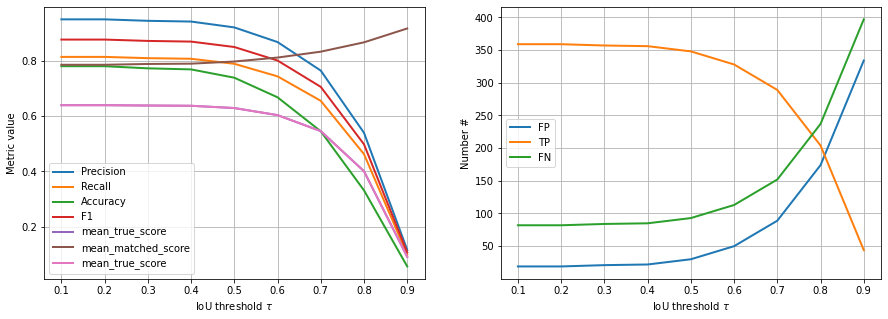

In [5]:
#Compute the segmentation efficiency metrics for the whole dataset
seg_efficiency_tot = eval_seg.evaluate_segementation_whole_dataset(Y, Y_pred, thresholds)
#plot the results
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
for m in ('Precision', 'Recall', 'Accuracy', 'F1', 'mean_true_score', 'mean_matched_score', 'mean_true_score'):
    ax1.plot(thresholds, seg_efficiency_tot[m], lw=2, label=m)
    ax1.set_xlabel(r'IoU threshold $\tau$')
    ax1.set_ylabel('Metric value')
    ax1.grid()
    ax1.legend()

for m in ('FP', 'TP', 'FN'):
    ax2.errorbar(thresholds, seg_efficiency_tot[m], lw=2, label=m)
    ax2.set_xlabel(r'IoU threshold $\tau$')
    ax2.set_ylabel('Number #')
    ax2.grid()
    ax2.legend();

#Save the results
seg_efficiency_tot.to_csv(output_dir+"segmentation_efficiencies_whole_dataset.csv")

### Effciencies accross different images

Below is a representation of the aforementioned metrics for each image at various IoU thresholds.

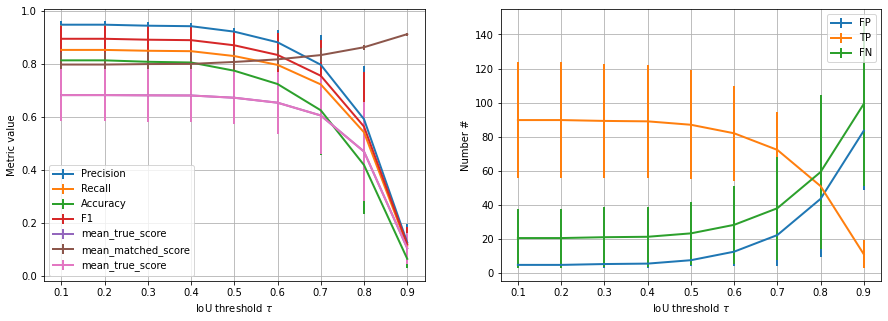

In [6]:
#Compute the segmentation efficiency metrics for a list of IoU thresholds for each image.
seg_efficiency_img = []
for index in range(len(Y)):
    seg_efficiency_img.append(eval_seg.evaluate_segementation_per_image(Y[index], Y_pred[index], thresholds, 
                                                        y[index].rsplit('/', 1)[-1][:-4]))
    
#plot the results
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
for m in ('Precision', 'Recall', 'Accuracy', 'F1', 'mean_true_score', 'mean_matched_score', 'mean_true_score'):
    ax1.errorbar(thresholds, np.mean([seg_efficiency_img[a][m] for a in range(0,len(Y))],axis=0),
                 yerr = np.std([seg_efficiency_img[a][m] for a in range(0,len(Y))],axis=0), lw=2, label=m)
    ax1.set_xlabel(r'IoU threshold $\tau$')
    ax1.set_ylabel('Metric value')
    ax1.grid()
    ax1.legend()

for m in ('FP', 'TP', 'FN'):
    ax2.errorbar(thresholds, np.mean([seg_efficiency_img[a][m] for a in range(0,len(Y))],axis=0),
                 yerr = np.std([seg_efficiency_img[a][m] for a in range(0,len(Y))],axis=0), lw=2, label=m)
    ax2.set_xlabel(r'IoU threshold $\tau$')
    ax2.set_ylabel('Number #')
    ax2.grid()
    ax2.legend();

#Save the results
seg_efficiency_img_f = pd.concat(seg_efficiency_img)
seg_efficiency_img_f.to_csv(output_dir+"segmentation_efficiencies_per_image.csv")

## Is this efficiency good enough?

A low effciency is a result of many factors including poor model performance, imprecise ground ruth boundaries. But in order to make sure that the segmentation is of acceptable quality we compute the Recall at 0.7 IoU threshold and the average F1 score across all thresholds. This is based on the 2018 DBS nuclear segmentation challenge.

The top performers in the challenge[ref1] had 

    1. recall of 77.62, 69.14, 68.07 and 59.35 at 0.7 IoU threshold.
    2. Average F1 scores of 0.7120, 0.6987, 0.7008 and 0.6280 across all thresholds

Stardist paper[ref3] achieved average precision/accuracy of 0.6850 on the 2018 DBS dataset. 

TO DO: compare these metrics for other more recent methods and evaluate model against available benchmarking datasets[ref2]


In [7]:
pd.DataFrame( {"recall_whole_dataset" :seg_efficiency_tot['Recall'][thresholds.index(0.7)],
               "estimated_recall_across_images" : np.mean([seg_efficiency_img[a]['Recall'] for a in range(0,len(Y))]),
               "StdDev_recall_across_images" : np.std([seg_efficiency_img[a]['Recall'] for a in range(0,len(Y))]),
               "Average_F1_whole_dataset" : np.mean(seg_efficiency_tot['F1']),
               "estimated_Average_F1_across_images" : np.mean(seg_efficiency_img_f['F1']),
               "std_Average_F1_across_images" :np.std(seg_efficiency_tot['F1'])}, index=[0])


pd.DataFrame( {"Level" : ['whole_dataset', ' estimated_across_images', 'StdDev_across_images'],
               "Recall_0.7_IoU" : [seg_efficiency_tot['Recall'][thresholds.index(0.7)],
                                   np.mean([seg_efficiency_img[a]['Recall'] for a in range(0,len(Y))]),
                                   np.std([seg_efficiency_img[a]['Recall'] for a in range(0,len(Y))])],
               "Average_F1" : [np.mean(seg_efficiency_tot['F1']),
                               np.mean(seg_efficiency_img_f['F1']),
                               np.std(seg_efficiency_tot['F1'])],
               "Accuracy" : [seg_efficiency_tot['Accuracy'][thresholds.index(0.7)],
                             np.mean([seg_efficiency_img[a]['Accuracy'] for a in range(0,len(Y))]),
                             np.std([seg_efficiency_img[a]['Accuracy'] for a in range(0,len(Y))])]})


,Level,Recall_0.7_IoU,Average_F1,Accuracy
0,whole_dataset,0.655329,0.717406,0.545283
1,estimated_across_images,0.712511,0.746367,0.650136
2,StdDev_across_images,0.261872,0.245499,0.265118


### Reference
1. Caicedo JC, Goodman A, Karhohs KW, et al. Publisher Correction: Nucleus segmentation across imaging experiments: the 2018 Data Science Bowl. Nat Methods. 2020;17(2):241. doi:10.1038/s41592-020-0733-z
2. Schmidt, Uwe, et al. "Cell detection with star-convex polygons." International Conference on Medical Image Computing and Computer-Assisted Intervention. Springer, Cham, 2018.
2. Ljosa, Vebjorn et al. “Annotated high-throughput microscopy image sets for validation.” Nature methods vol. 9,7 637. 28 Jun. 2012, doi:10.1038/nmeth.2083
